In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from brian2 import *

from utils.funcs import basic_namespace, plot_v_by_equation
from utils.equations import dndt

prefs.codegen.target = "numpy"

In [95]:
nav11_eq = Equations(
    """
INav11 = gNav11 * m**3 * h * s * (Ena - v) : ampere
m_inf = 1 / (1 + exp(-(v/mV + 21.2)/4.9)) : 1
m_tau = 0.15 * ms : second
dm/dt = (m_inf - m) / m_tau : 1
dh/dt = (h_inf - h) / h_tau : 1
h_inf = 1 / (1 + exp((v/mV + 39.7)/7.7)) : 1
h_tau = 20.1 * ms * exp(-0.5 * ((v/mV + 61.4)/32.7)**2) : second
s_inf = 1 / (1 + exp((v/mV + 46.1)/5.4)) : 1
s_tau = 106.7 * exp(-0.5 * ((v/mV + 52.7)/18.3)**2)*ms : second
ds/dt = (s_inf - s) / s_tau : 1
    """,
    m="mNa11", h="hNa11", m_inf="mNa11_inf", m_tau="mNa11_tau", h_inf="hNa11_inf", h_tau="hNa11_tau",
)

In [19]:
basic_namespace

{'Cm': 20. * pfarad,
 'Ena': 55. * mvolt,
 'Ek': -85. * mvolt,
 'El': -70. * mvolt,
 'gK': 40. * nsiemens,
 'gL': 3. * nsiemens,
 'gNa': 50. * nsiemens,
 'gNa18': 100. * nsiemens,
 'VT': -63. * mvolt}

In [ ]:
dn/dt = (n_inf - n) / n_tau : 1  # from paper
a_n = -0.07 * (v/mV - 47) / (1 - exp((v/mV - 47)/(-6))) / ms : Hz
b_n = 0.264 * exp((v/mV - 22)/4) /ms : Hz
n_inf = a_n / (a_n + b_n) : 1
n_tau = 1 / (a_n + b_n) : second

In [127]:
start_scope()
test_namespace = basic_namespace.copy()
test_namespace["gNav11"] = 100 * nS
test_namespace["gL"] = 2 *nS
test_namespace["gK"] = 40*nS
test_master_eq = Equations(
    """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + INav11 + I) / Cm : volt
I : ampere
dn/dt = (n_inf - n) / n_tau : 1  # from paper
a_n = 0.07 * 6 / exprel((v/mV - 47)/(-6))/ms : Hz
b_n = 0.264 * exp((v/mV - 22)/4) /ms : Hz
n_inf = a_n / (a_n + b_n) : 1
n_tau = 1 / (a_n + b_n) : second
"""
)
test_eq = test_master_eq + nav11_eq
defaultclock.dt = 0.1*ms
test_neuron = NeuronGroup(1, test_eq, method="euler", namespace=test_namespace)
test_mon = StateMonitor(test_neuron, ["v", "n", "mNa11", "hNa11"], record=True)
test_neuron.v = -65 * mV
run(50*ms)
test_neuron.I = 100 * pA
run(100*ms)

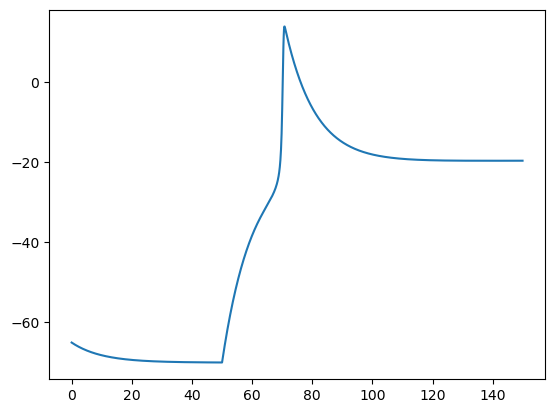

In [128]:
plot(test_mon.t/ms, test_mon.v[0]/mV)

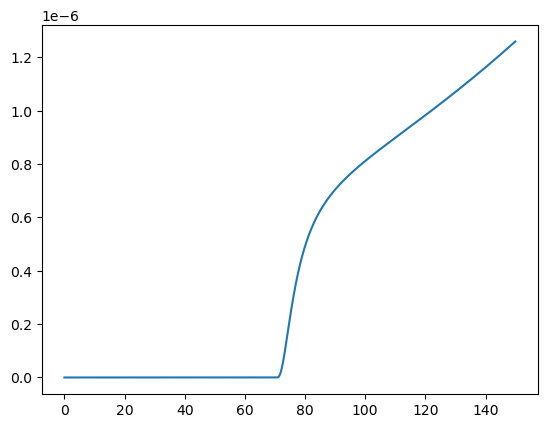

In [129]:
plot(test_mon.t/ms, test_mon.n[0]**4)

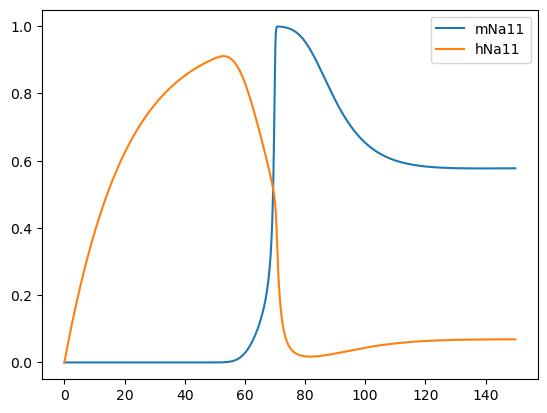

In [130]:
plot(test_mon.t/ms, test_mon.mNa11[0], label="mNa11")
plot(test_mon.t/ms, test_mon.hNa11[0], label="hNa11")
legend()

In [135]:
vv = linspace(-80, 20, 10000)
a_n = -0.07 * (vv - 47) / (1 - exp((vv - 47)/(-6)))
a_n = -0.07 * 6 / exprel((vv - 47)/(-6))
b_n = 0.264 * exp((vv - 22)/4)

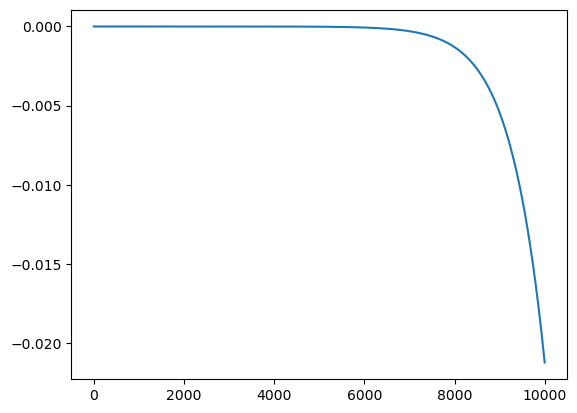

In [137]:
plot(a_n)

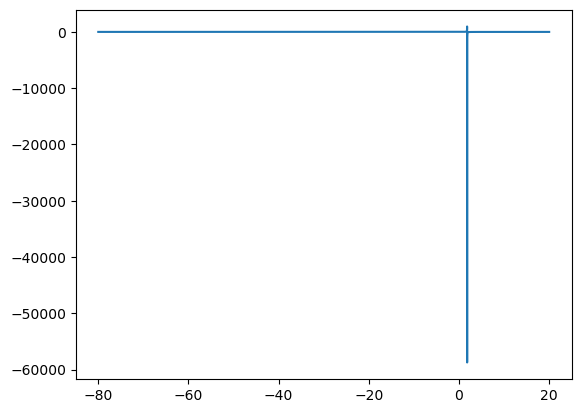

In [136]:
plot(vv, a_n / (a_n + b_n))